In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **CLIP-I, CLIP-T, DINO**

- **CLIP-I** - average pairwise cosine similarity between CLIP embeddings of generated and real images
- **CLIP-T** - average cosine similarity between prompt and CLIP embeddings of generated images
- **DINO** - average pairwise cosine similarity between the Vit-S/16 DINO embeddings of generated and real images

In [180]:
import os

os.chdir("/net/tscratch/people/plglukaszst/projects/ziplora-analysis/")

In [181]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.nn import functional as F
from transformers import AutoModel, AutoProcessor, AutoTokenizer
import argparse
import os

import torch
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline
import itertools


In [182]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [183]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [184]:
def get_model_outs(pretrained_model_name_or_path: str, prompts:list, samples_per_prompt: int):
    model_path = pretrained_model_name_or_path
    diffusion_pipe = DiffusionPipeline.from_pretrained(
        model_path, torch_dtype=torch.float16
    )
    diffusion_pipe = diffusion_pipe.to("cuda")
    generator = torch.Generator("cuda")
    generator = generator.manual_seed(0)

    tasks_prompts = []
    tasks_samples = []
    for current_prompt in prompts:
        task_prompts = [current_prompt] * samples_per_prompt
        task_samples = diffusion_pipe(
            prompt=task_prompts, output_type="pil", generator=generator
        )
        task_prompts.append(task_prompts)
        tasks_samples.append(task_samples)

    return tasks_prompts, list(itertools.chain.from_iterable([out.images for out in tasks_samples]))

In [185]:
N_TASKS = 5
MODELS = ["watercolor_painting_style_sd1_rank64", "oil_painting_style_sd2_rank64", "colored_smoke_style_sd3_rank64", "wooden_sculpture_style_sd4_rank64", "cartoon_line_drawing_style_sd5_rank64"]
TOKENS = ["skn style", "zwz style", "sbu style", "uwu style", "pdw style"]
AFTER_TASK_MODEL = {
    k+1:v for k,v in zip(range(N_TASKS), MODELS)
}
TOKEN_TASK = {
    k+1: v for k,v in zip(range(N_TASKS), MODELS)
}

PROMPTS = ['a wizard in {}', 'a policeman in {}', 'a santa hat in {}', 'a clock in {}', 'a mirror in {}']


In [189]:
def run_model(task_number):
    if task_number >= 1:
        per_task_outs = {}
        for curr_task_number in range(task_number):
            task_outs = {}
            model_path = f"./models/rank/style/{AFTER_TASK_MODEL[task_number]}"
            prompts = [
                prompt.format(TOKEN_TASK[curr_task_number+1]) for prompt in PROMPTS
            ]
            out_prompts, out_samples = get_model_outs(pretrained_model_name_or_path=model_path, prompts=prompts, samples_per_prompt=8)
            task_outs["prompts"] = out_prompts
            task_outs["samples"] = out_samples
            per_task_outs[curr_task_number+1] = task_outs
        return per_task_outs
    else:
        per_task_outs = {}
        for curr_task_number in range(5):
            task_outs = {}
            model_path = f"stabilityai/stable-diffusion-xl-base-1.0"
            prompts = [
                prompt.format(TOKEN_TASK[curr_task_number+1]) for prompt in PROMPTS
            ]
            out_prompts, out_samples = get_model_outs(pretrained_model_name_or_path=model_path, prompts=prompts, samples_per_prompt=8)
            task_outs["prompts"] = out_prompts
            task_outs["samples"] = out_samples
            per_task_outs[curr_task_number+1] = task_outs
        return per_task_outs

In [ ]:
task_outs_0 = run_model(0)

In [222]:
task_outs_1 = run_model(1)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [223]:
task_outs_2 = run_model(2)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [224]:
task_outs_3 = run_model(3)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [225]:
task_outs_4 = run_model(4)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [226]:
task_outs_5 = run_model(5)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [238]:
# import pickle

# with open("results_rank4.pkl", "wb") as f:
#     pickle.dump([task_outs_0,task_outs_1,task_outs_2,task_outs_3,task_outs_4,task_outs_5],f)

In [248]:
with open("results_rank4.pkl", "rb") as f:
    xd = pickle.load(f)

In [240]:
xd[0]

{1: {'prompts': [],
  'samples': [<PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RGB size=1024x1024>,
   <PIL.Image.Image image mode=RG

# Metrics

In [249]:
DATASETS = ["watercolor_painting_style", "oil_painting_style", "colored_smoke_style", "wooden_sculpture_style", "cartoon_line_drawing_style"]

In [250]:
from lora.metrics import clip_image_metric, dino_metric

In [251]:
for task in range(5):
    model_samples = xd[0][task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

/net/tscratch/people/plglukaszst/envs/lora/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Task number: 0, CLIP: 0.5936103463172913, DINO: 0.2218233197927475
Task number: 1, CLIP: 0.5600571632385254, DINO: 0.07089140266180038
Task number: 2, CLIP: 0.6261627078056335, DINO: 0.18653252720832825
Task number: 3, CLIP: 0.6517712473869324, DINO: 0.2567393481731415
Task number: 4, CLIP: 0.4985247552394867, DINO: 0.42831817269325256


In [242]:
for task in range(1):
    model_samples = xd[1][task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6175274848937988, DINO: 0.36399126052856445


In [243]:
for task in range(2):
    model_samples = xd[2][task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6069194674491882, DINO: 0.3119345009326935
Task number: 1, CLIP: 0.5950239300727844, DINO: 0.22147221863269806


In [244]:
for task in range(3):
    model_samples = xd[3][task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6238088607788086, DINO: 0.2925003468990326
Task number: 1, CLIP: 0.5929635167121887, DINO: 0.1299789398908615
Task number: 2, CLIP: 0.6789082884788513, DINO: 0.2717847228050232


In [245]:
for task in range(4):
    model_samples = xd[4][task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6250138282775879, DINO: 0.2822725176811218
Task number: 1, CLIP: 0.5691311955451965, DINO: 0.11586395651102066
Task number: 2, CLIP: 0.6546646356582642, DINO: 0.09583880752325058
Task number: 3, CLIP: 0.7081984877586365, DINO: 0.4172306954860687


In [246]:
for task in range(5):
    model_samples = xd[5][task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6035056114196777, DINO: 0.29515132308006287
Task number: 1, CLIP: 0.5694054365158081, DINO: 0.06859054416418076
Task number: 2, CLIP: 0.6418136358261108, DINO: 0.1970469355583191
Task number: 3, CLIP: 0.6867523193359375, DINO: 0.3445904552936554
Task number: 4, CLIP: 0.4970206320285797, DINO: 0.4175999164581299


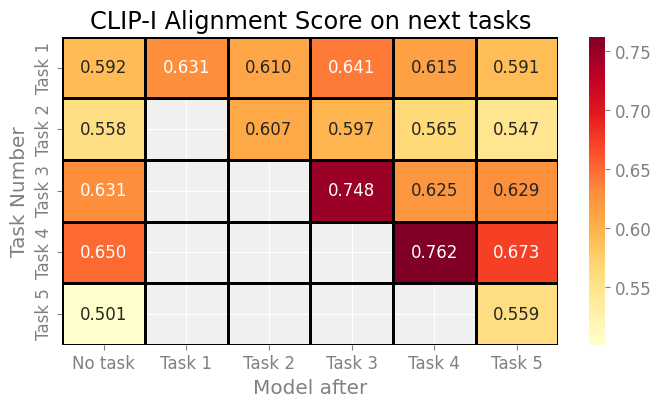

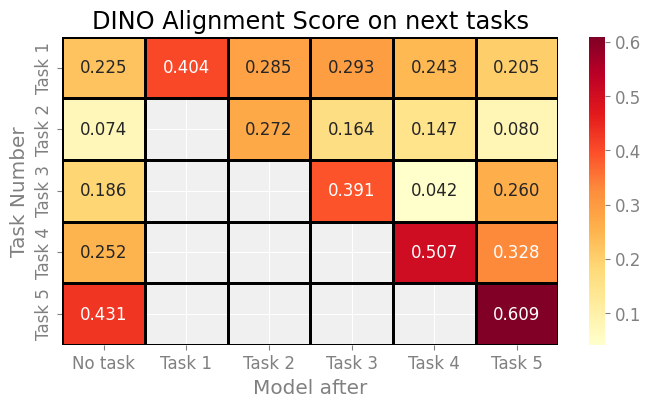

In [255]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Creating a matrix for the incremental model performance for heatmap
clip_matrix_updated = np.array([
    [0.5915667414665222, 0.557922899723053, 0.631373405456543, 0.649736762046814, 0.5014150142669678],
    [0.6314317584037781, np.nan, np.nan, np.nan, np.nan],
    [0.6097226142883301, 0.6070818305015564, np.nan, np.nan, np.nan],
    [0.6411687135696411, 0.5970920920372009, 0.7478613257408142, np.nan, np.nan],
    [0.6149083375930786, 0.5654003024101257, 0.6246252059936523, 0.7621899843215942, np.nan],
    [0.5909754633903503, 0.5474587678909302, 0.6293401122093201, 0.6726295351982117, 0.5590265393257141]
]).T

dino_matrix_updated = np.array([
    [0.22539949417114258, 0.07449301332235336, 0.18638978898525238, 0.2520217299461365, 0.4309535622596741],
    [0.4041808545589447, np.nan, np.nan, np.nan, np.nan],
    [0.28482845425605774, 0.2720974087715149, np.nan, np.nan, np.nan],
    [0.29327940940856934, 0.16400940716266632, 0.39082106947898865, np.nan, np.nan],
    [0.24281631410121918, 0.14737513661384583, 0.04183489456772804, 0.5071339011192322, np.nan],
    [0.20504982769489288, 0.07990869134664536, 0.25962793827056885, 0.32778987288475037, 0.6091178059577942]
]).T

tasks = ['No task','Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5']
colormap = 'YlOrRd'

# Plotting the heatmap for CLIP metric
plt.figure(figsize=(8, 4))
sns.heatmap(clip_matrix_updated, annot=True, fmt=".3f", cmap=colormap, xticklabels=tasks, yticklabels=tasks[1:], linewidths=.9, linecolor='black')
plt.title('CLIP-I Alignment Score on next tasks')
plt.xlabel('Model after')
plt.ylabel('Task Number')
plt.savefig("fig1styler256.svg")
plt.show()

# Plotting the heatmap for DINO metric
plt.figure(figsize=(8, 4))
sns.heatmap(dino_matrix_updated, annot=True, fmt=".3f", cmap=colormap, xticklabels=tasks, yticklabels=tasks[1:], linewidths=.9, linecolor='black')
plt.title('DINO Alignment Score on next tasks')
plt.xlabel('Model after')
plt.ylabel('Task Number')
plt.savefig("fig2styler256.svg")
plt.show()

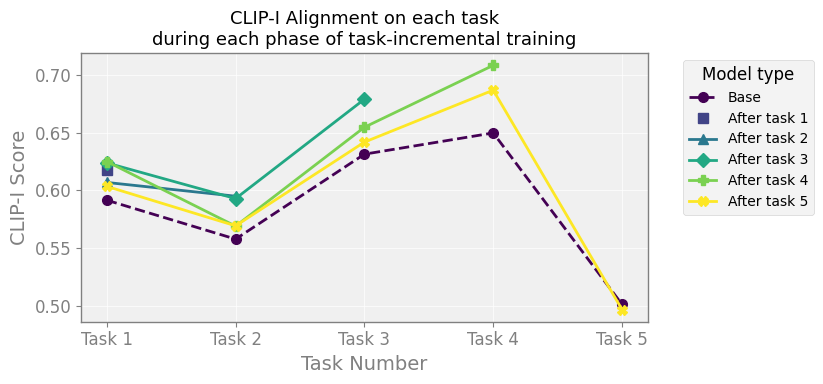

In [216]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot style and colors
plt.style.use('ggplot')
plt.rcParams.update({
    'axes.facecolor': '#f0f0f0',  # Light gray background for the plot area
    'figure.facecolor': '#ffffff',  # Light gray background for the figure
    'grid.color': 'white',
    'axes.edgecolor': 'gray',
    'axes.linewidth': 1.0,
    'axes.labelcolor': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray',
    'font.size': 12,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'figure.figsize': (14, 7)
})

plt.figure(figsize=(10, 4))

# Transpose the matrix for easier plotting
clip_matrix_updated_transposed = clip_matrix_updated.T

# Define a list of colors for each task finished
colors = plt.cm.viridis(np.linspace(0, 1, clip_matrix_updated_transposed.shape[1] + 1))
markers = ['o', 's', '^', 'D', 'P', 'X', 'H']

for task_finished in range(clip_matrix_updated_transposed.shape[1] + 1):
    if task_finished == 0:
        y = clip_matrix_updated_transposed[0, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='--', linewidth=2, markersize=7, label='Base')
    elif task_finished == 1:
        y = clip_matrix_updated_transposed[task_finished, 0]
        x = [1]
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='', markersize=7, label=f'After task {task_finished}')
    else:
        y = clip_matrix_updated_transposed[task_finished, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='-', linewidth=2, markersize=7, label=f'After task {task_finished}')

# Add title and labels
plt.title('CLIP-I Alignment on each task\nduring each phase of task-incremental training', fontsize=13)
plt.xlabel('Task Number', fontsize=14, color='gray')
plt.ylabel('CLIP-I Score', fontsize=14, color='gray')
plt.xticks(ticks=np.arange(1, len(tasks)), labels=tasks[1:], fontsize=12, color='gray')
plt.yticks(fontsize=12, color='gray')

# Add legend and grid
plt.legend(title='Model type', fontsize=10, title_fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='-', linewidth=0.7, color='white', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("fig3style.svg")

plt.show()


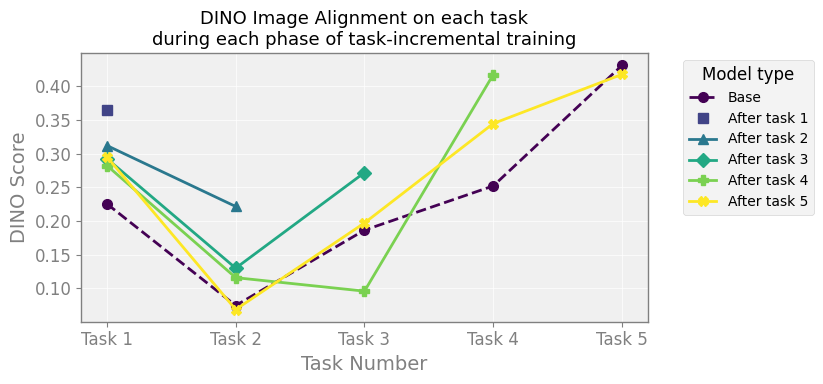

In [217]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot style and colors
plt.style.use('ggplot')
plt.rcParams.update({
    'axes.facecolor': '#f0f0f0',  # Light gray background for the plot area
    'figure.facecolor': '#ffffff',  # Light gray background for the figure
    'grid.color': 'white',
    'axes.edgecolor': 'gray',
    'axes.linewidth': 1.0,
    'axes.labelcolor': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray',
    'font.size': 12,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'figure.figsize': (14, 7)
})

plt.figure(figsize=(10, 4))

# Transpose the matrix for easier plotting
dino_matrix_updated_transposed = dino_matrix_updated.T

# Define a list of colors for each task finished
colors = plt.cm.viridis(np.linspace(0, 1, dino_matrix_updated_transposed.shape[1] + 1))
markers = ['o', 's', '^', 'D', 'P', 'X', 'H']

for task_finished in range(dino_matrix_updated_transposed.shape[1] + 1):
    if task_finished == 0:
        y = dino_matrix_updated_transposed[0, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='--', linewidth=2, markersize=7, label='Base')
    elif task_finished == 1:
        y = dino_matrix_updated_transposed[task_finished, 0]
        x = [1]
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='', markersize=7, label=f'After task {task_finished}')
    else:
        y = dino_matrix_updated_transposed[task_finished, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='-', linewidth=2, markersize=7, label=f'After task {task_finished}')

# Add title and labels
plt.title('DINO Image Alignment on each task\nduring each phase of task-incremental training', fontsize=13)
plt.xlabel('Task Number', fontsize=14, color='gray')
plt.ylabel('DINO Score', fontsize=14, color='gray')
plt.xticks(ticks=np.arange(1, len(tasks)), labels=tasks[1:], fontsize=12, color='gray')
plt.yticks(fontsize=12, color='gray')

# Add legend and grid
plt.legend(title='Model type', fontsize=10, title_fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='-', linewidth=0.7, color='white', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("fig4style.svg")

plt.show()


In [256]:
def calculate_final_metrics(accuracy_matrix):
    T = accuracy_matrix.shape[0]
    
    # Calculate average accuracy
    avg_accuracies = []
    for i in range(T):
        valid_accuracies = [accuracy_matrix[i, j] for j in range(i + 1) if not np.isnan(accuracy_matrix[i, j])]
        if valid_accuracies:
            avg_accuracies.append(np.mean(valid_accuracies))
    final_avg_accuracy = np.mean(avg_accuracies)
    
    # Calculate average forgetting
    forgetting_values = []
    for j in range(T):
        task_accuracies = [accuracy_matrix[i, j] for i in range(T) if not np.isnan(accuracy_matrix[i, j])]
        if len(task_accuracies) > 1:
            initial_accuracy = task_accuracies[0]
            max_forgetting = max(initial_accuracy - acc for acc in task_accuracies[1:])
            forgetting_values.append(max_forgetting)
    final_avg_forgetting = np.mean(forgetting_values) if forgetting_values else 0.0
    
    return final_avg_accuracy, final_avg_forgetting

# Provided matrix
accuracy_matrix = np.array([
    [0.6314317584037781, np.nan, np.nan, np.nan, np.nan],
    [0.6097226142883301, 0.6070818305015564, np.nan, np.nan, np.nan],
    [0.6411687135696411, 0.5970920920372009, 0.7478613257408142, np.nan, np.nan],
    [0.6149083375930786, 0.5654003024101257, 0.6246252059936523, 0.7621899843215942, np.nan],
    [0.5909754633903503, 0.5474587678909302, 0.6293401122093201, 0.6726295351982117, 0.5590265393257141]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.6287083464860916, 0.0782189816236496)

In [257]:
accuracy_matrix = np.array([
    [0.4041808545589447, np.nan, np.nan, np.nan, np.nan],
    [0.28482845425605774, 0.2720974087715149, np.nan, np.nan, np.nan],
    [0.29327940940856934, 0.16400940716266632, 0.39082106947898865, np.nan, np.nan],
    [0.24281631410121918, 0.14737513661384583, 0.04183489456772804, 0.5071339011192322, np.nan],
    [0.20504982769489288, 0.07990869134664536, 0.25962793827056885, 0.32778987288475037, 0.6091178059577942]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.29928719405084847, 0.22991248685866594)

In [260]:
accuracy_matrix = np.array([
    [0.6175274848937988, np.nan, np.nan, np.nan, np.nan],
    [0.6069194674491882, 0.5950239300727844, np.nan, np.nan, np.nan],
    [0.6238088607788086, 0.5929635167121887, 0.6789082884788513, np.nan, np.nan],
    [0.6250138282775879, 0.5691311955451965, 0.6546646356582642, 0.7081984877586365, np.nan],
    [0.6035056114196777, 0.5694054365158081, 0.6418136358261108, 0.6867523193359375, 0.4970206320285797]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.6178688605626423, 0.02461385726928711)

In [261]:
accuracy_matrix = np.array([
    [0.36399126052856445, np.nan, np.nan, np.nan, np.nan],
    [0.3119345009326935, 0.22147221863269806, np.nan, np.nan, np.nan],
    [0.2925003468990326, 0.1299789398908615, 0.2717847228050232, np.nan, np.nan],
    [0.2822725176811218, 0.11586395651102066, 0.09583880752325058, 0.4172306954860687, np.nan],
    [0.29515132308006287, 0.06859054416418076, 0.1970469355583191, 0.3445904552936554, 0.4175999164581299]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.2709026572108269, 0.12079664319753647)

In [262]:
accuracy_matrix = np.array([
    [0.624005913734436, np.nan, np.nan, np.nan, np.nan],
    [0.6173079609870911, 0.6026208996772766, np.nan, np.nan, np.nan],
    [0.601495087146759, 0.5707738995552063, 0.6571434140205383, np.nan, np.nan],
    [0.6376327276229858, 0.5846818089485168, 0.6577308773994446, 0.6624749302864075, np.nan],
    [0.6157271862030029, 0.572004497051239, 0.6165396571159363, 0.6297092437744141, 0.5546650290489197]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.6154267372687657, 0.03193181753158569)

In [263]:
accuracy_matrix = np.array([
     [0.35372039675712585, np.nan, np.nan, np.nan, np.nan],
    [0.3050145208835602, 0.27117177844047546, np.nan, np.nan, np.nan],
    [0.23603737354278564, 0.06551206856966019, 0.1518050730228424, np.nan, np.nan],
    [0.27489903569221497, 0.12522797286510468, 0.0896523967385292, 0.3381164073944092, np.nan],
    [0.19007249176502228, 0.10566291958093643, 0.17658631503582, 0.19980619847774506, 0.5731788873672485]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.24979340674976508, 0.14244262501597404)

In [264]:
accuracy_matrix = np.array([
    [0.6340597867965698, np.nan, np.nan, np.nan, np.nan],
    [0.6207391619682312, 0.5846291184425354, np.nan, np.nan, np.nan],
    [0.626923680305481, 0.5861591696739197, 0.6827797293663025, np.nan, np.nan],
    [0.6323815584182739, 0.5890557765960693, 0.6782455444335938, 0.6898387670516968, np.nan],
    [0.6310593485832214, 0.5721332430839539, 0.6501951217651367, 0.669084370136261, 0.5528423190116882]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.6262282824516296, 0.019788876175880432)

In [266]:
accuracy_matrix = np.array([
    [0.3355186879634857, np.nan, np.nan, np.nan, np.nan],
    [0.3266209661960602, 0.16053076088428497, np.nan, np.nan, np.nan],
    [0.28707218170166016, 0.0950699970126152, 0.2956484258174896, np.nan, np.nan],
    [0.27234792709350586, 0.12154855579137802, 0.1563342958688736, 0.38109561800956726, np.nan],
    [0.2462640255689621, 0.07805424183607101, 0.2054959386587143, 0.27056682109832764, 0.5811710357666016]
])

final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.2628333529581626, 0.10539352707564831)

In [269]:
accuracy_matrix = np.array([
    [0.793428897857666, np.nan, np.nan, np.nan, np.nan],
    [0.7774552702903748, 0.6929765939712524, np.nan, np.nan, np.nan],
    [0.7595664858818054, 0.6193699836730957, 0.8358353972434998, np.nan, np.nan],
    [0.7758440375328064, 0.6356817483901978, 0.8082953691482544, 0.8604705929756165, np.nan],
    [0.7445307970046997, 0.7092705368995667, 0.7584363222122192, 0.7216531038284302, 0.7989634871482849]
])
final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting


(0.7567091810703277, 0.08468031883239746)

In [270]:
accuracy_matrix = np.array([
    [0.7291561365127563, np.nan, np.nan, np.nan, np.nan],
    [0.6832629442214966, 0.4377683699131012, np.nan, np.nan, np.nan],
    [0.5687738656997681, 0.2634895443916321, 0.7843140363693237, np.nan, np.nan],
    [0.5982953906059265, 0.3198055922985077, 0.7366825342178345, 0.5764378905296326, np.nan],
    [0.5000820159912109, 0.4243290424346924, 0.5995821952819824, 0.45259878039360046, 0.6105648875236511]
])
final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.5807535357276599, 0.17798097431659698)

In [271]:
accuracy_matrix = np.array([
    [0.7672311663627625, np.nan, np.nan, np.nan, np.nan],
    [0.7478558421134949, 0.8447762727737427, np.nan, np.nan, np.nan],
    [0.6973913311958313, 0.7606914639472961, 0.8467984199523926, np.nan, np.nan],
    [0.7652674059867859, 0.7815966010093689, 0.7972794771194458, 0.6590635180473328, np.nan],
    [0.699261486530304, 0.7893842458724976, 0.7865535616874695, 0.6152812242507935, 0.8123960494995117]
])
final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting


(0.7646436052560807, 0.06448794901371002)

In [272]:
accuracy_matrix = np.array([
    [0.6100791692733765, np.nan, np.nan, np.nan, np.nan],
    [0.560372531414032, 0.5591630339622498, np.nan, np.nan, np.nan],
    [0.454707533121109, 0.46327629685401917, 0.8003391623497009, np.nan, np.nan],
    [0.5761002898216248, 0.47583648562431335, 0.6626940965652466, 0.37658119201660156, np.nan],
    [0.46788525581359863, 0.4650656282901764, 0.6821586489677429, 0.23177675902843475, 0.7166255712509155]
])
final_avg_accuracy, final_avg_forgetting = calculate_final_metrics(accuracy_matrix)
final_avg_accuracy, final_avg_forgetting

(0.555625334282716, 0.1334269680082798)